In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df=pd.read_csv("PGCB_Demand_Data_2021.csv")
df["DateTime"] = pd.to_datetime(df.date.astype(str) + ' ' + df.hour.astype(str), format='%m/%d/%Y %H')
df["DateTime"]=pd.to_datetime(df["DateTime"])
df.set_index("DateTime",inplace=True)
df

,date,year,month,day,weekday,hour,demand
DateTime,,,,,,,
2018-01-01 00:00:00,1/1/2018,2018,1,1,2,0,5673.00
2018-01-01 01:00:00,1/1/2018,2018,1,1,2,1,5183.00
2018-01-01 02:00:00,1/1/2018,2018,1,1,2,2,4908.00
2018-01-01 03:00:00,1/1/2018,2018,1,1,2,3,4786.00
2018-01-01 04:00:00,1/1/2018,2018,1,1,2,4,4599.00
...,...,...,...,...,...,...,...
2021-03-15 19:00:00,3/15/2021,2021,3,15,2,19,10321.02
2021-03-15 20:00:00,3/15/2021,2021,3,15,2,20,11242.00
2021-03-15 21:00:00,3/15/2021,2021,3,15,2,21,10994.12


In [3]:
df.shape

(28080, 7)

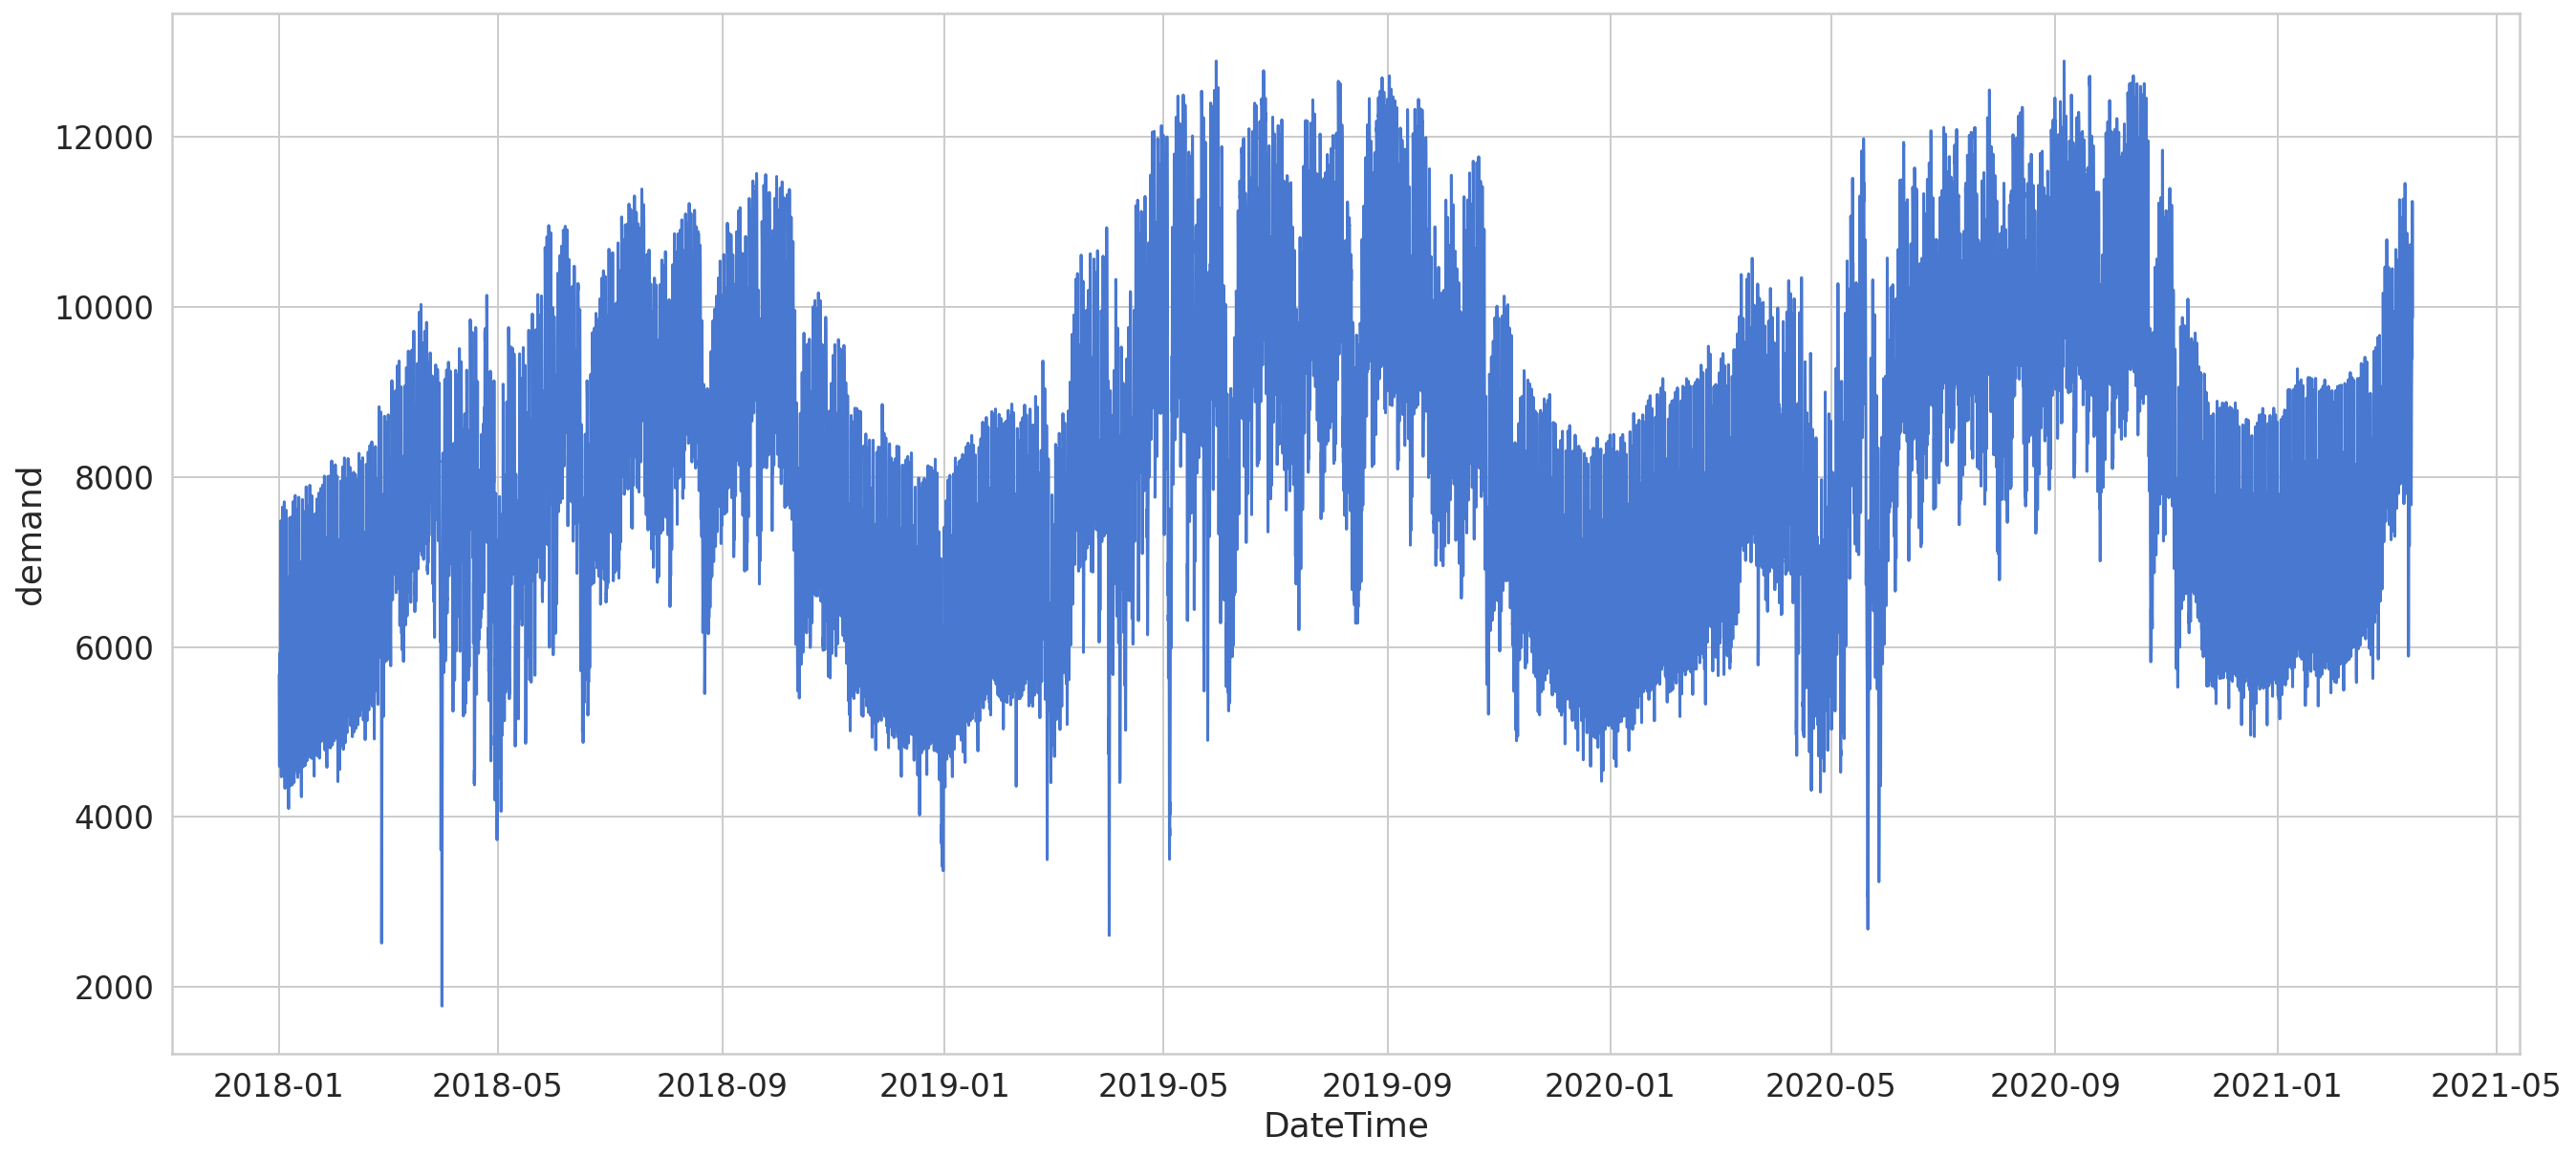

In [4]:
sns.lineplot(x=df.index, y="demand", data=df);

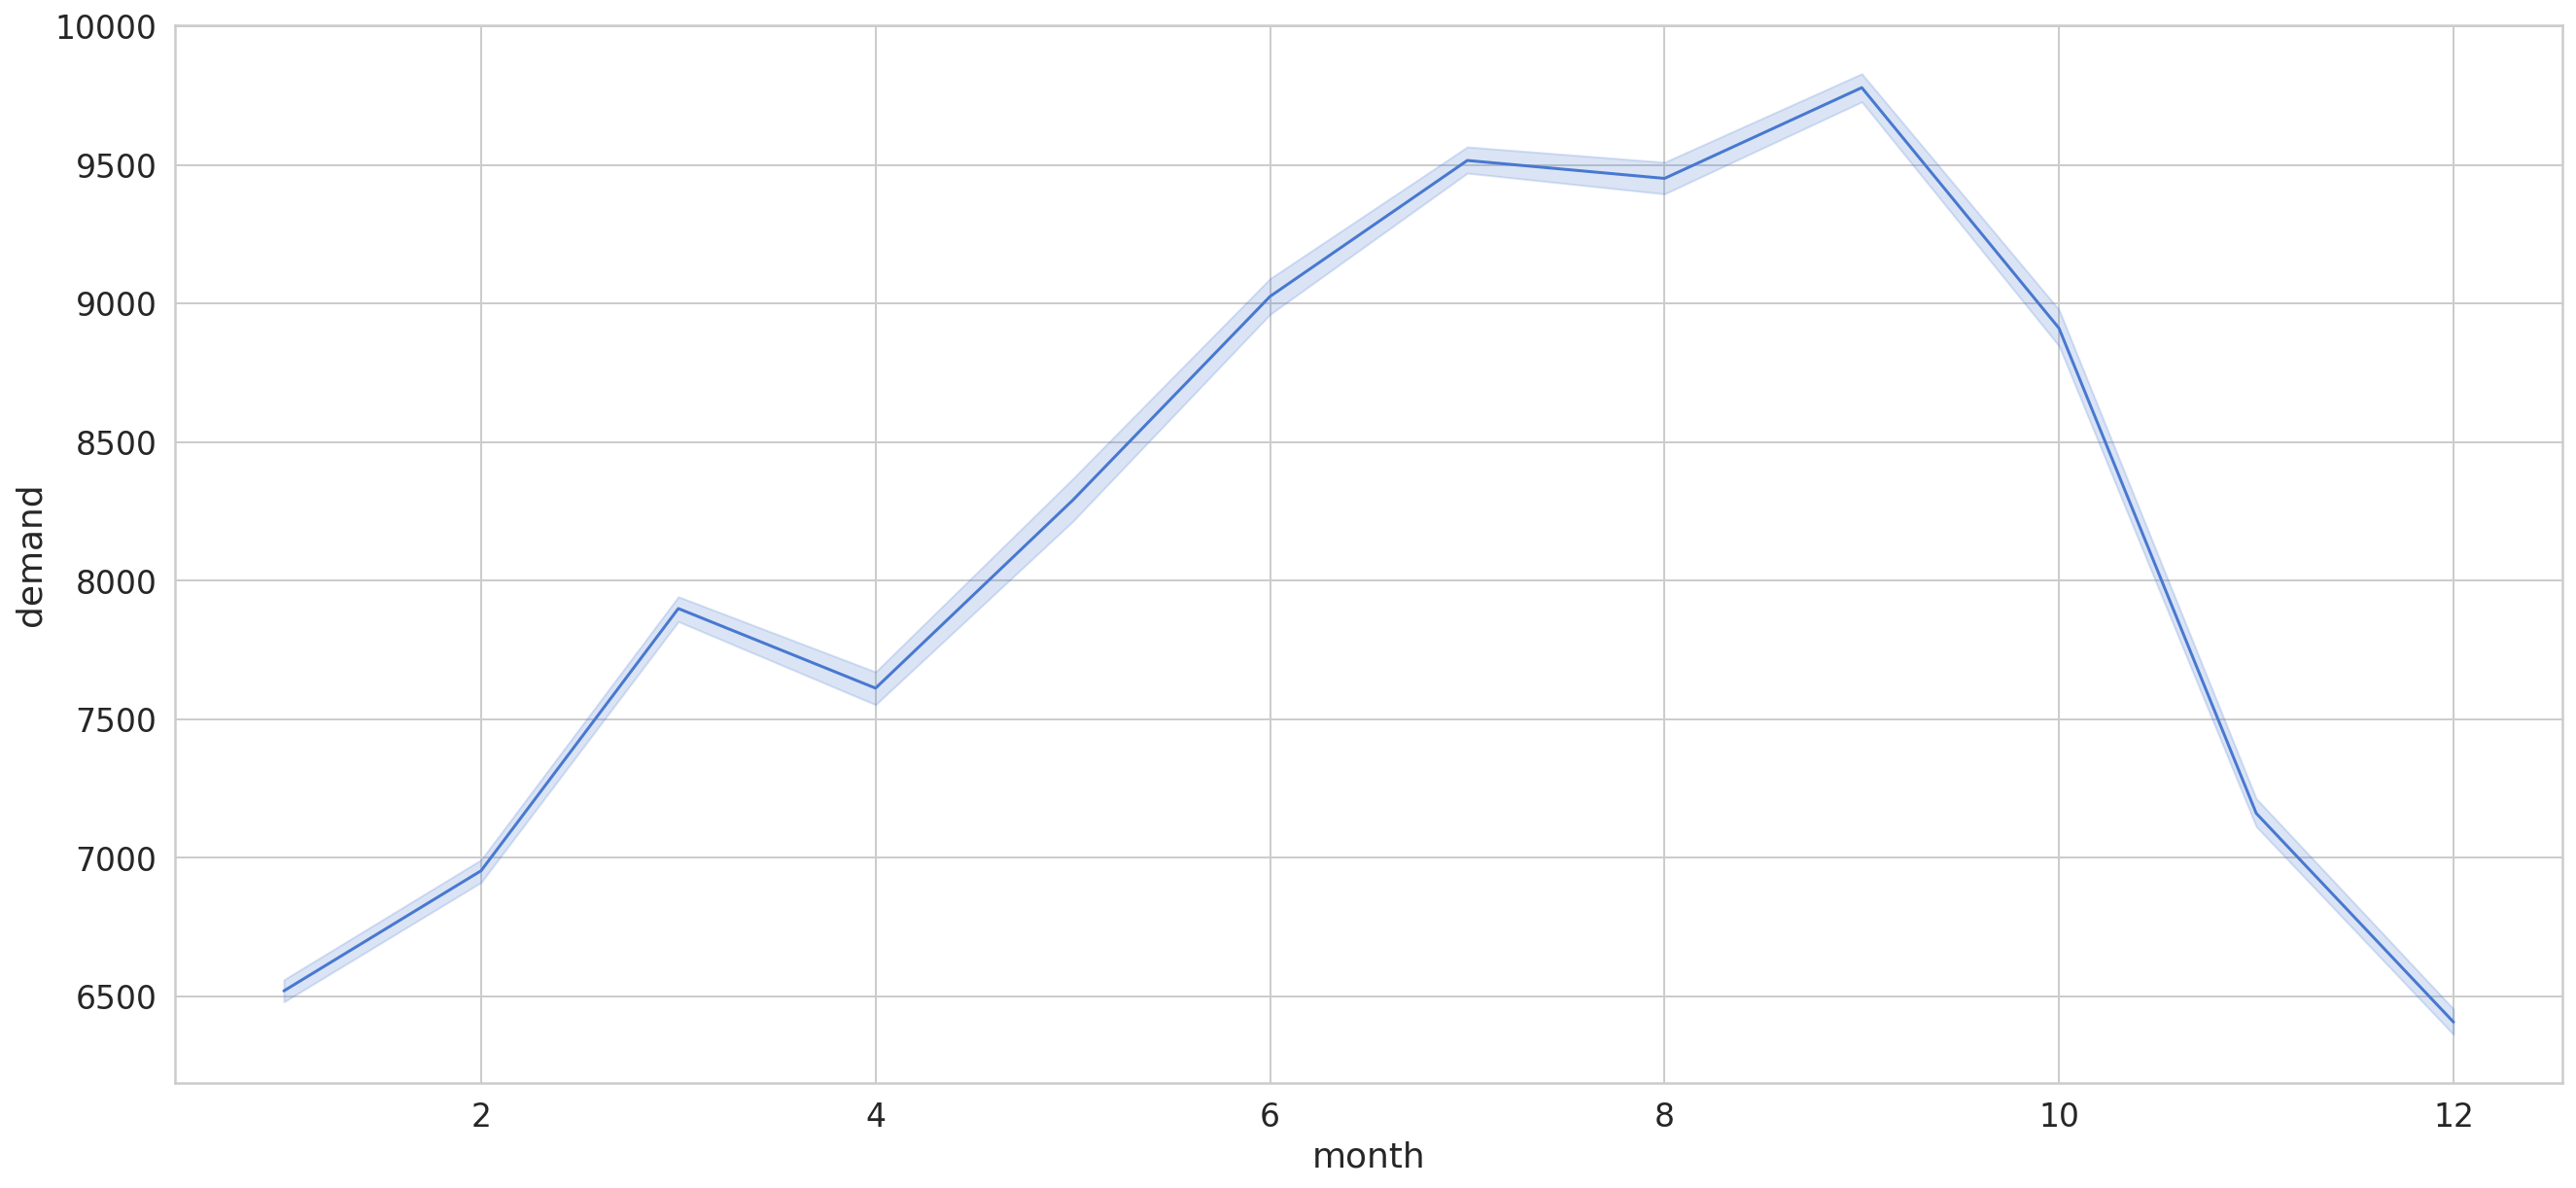

In [5]:
sns.lineplot(x='month', y="demand", data=df);

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(df["demand"],
                             model='additive'
                             )

In [7]:
trend=decomposed.trend
sesonal=decomposed.seasonal
residual=decomposed.resid

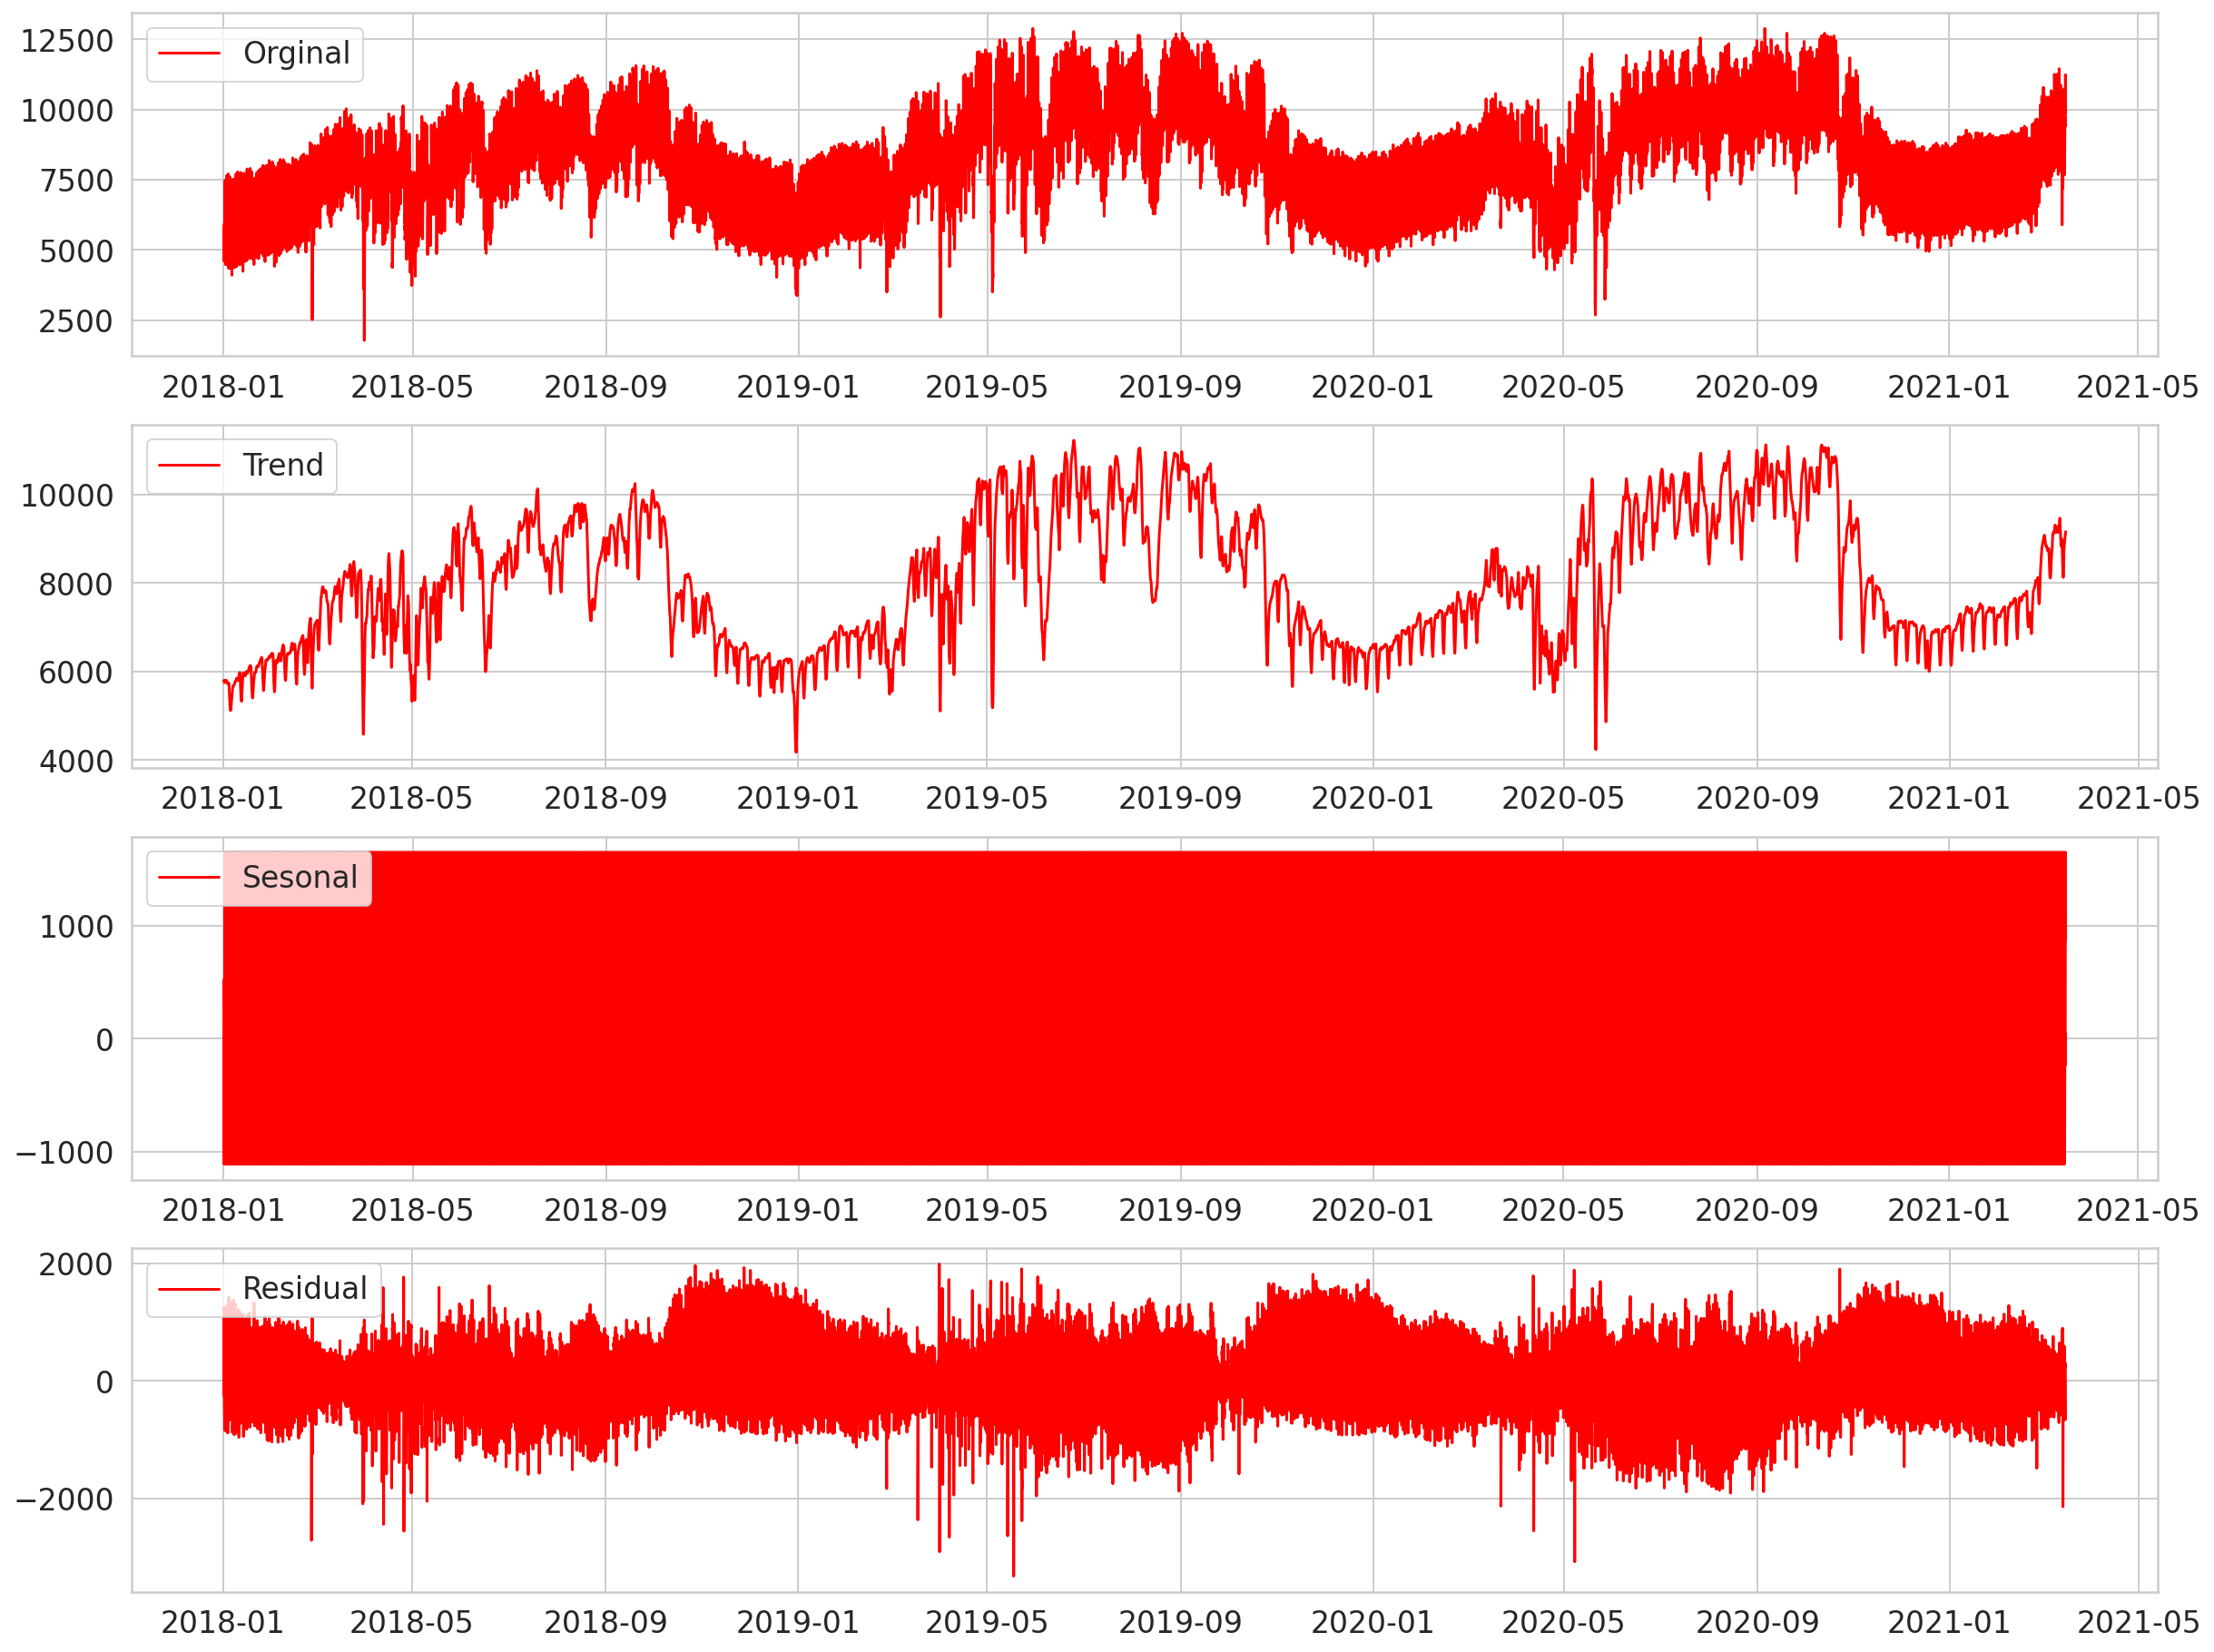

In [8]:
plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df["demand"],label="Orginal",color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label="Trend",color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sesonal,label="Sesonal",color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label="Residual",color='red')
plt.legend(loc='upper left')
plt.show()

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler(feature_range=(0,1))
# X=scaler.fit_transform(df.demand.values.reshape(-1,1))
D_max_daily = df.groupby(df.index).demand.max().to_numpy()
df.demand= df.demand/max(D_max_daily)
D_max=max(D_max_daily)

In [10]:
##splitting dataset into train and test split
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data,test_data=df.demand[0:training_size],df.demand[training_size:len(df)]

In [11]:
train=train_data.values.reshape(-1,1)
test=test_data.values.reshape(-1,1)

In [12]:
train.shape

(18252, 1)

In [13]:
test.shape

(9828, 1)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 24*7 # take time laps for 7 days
X_train, y_train = create_dataset(train, time_step)
X_test, ytest = create_dataset(test, time_step)

In [16]:
print(X_train.shape)
print(y_train.shape)

(18083, 168)
(18083,)


In [17]:
print(X_test.shape)
print(ytest.shape)

(9659, 168)
(9659,)


In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
print(X_train.shape)
print(y_train.shape)

(18083, 168, 1)
(18083,)


In [20]:
X_train

array([[[0.4400062 ],
        [0.40200109],
        [0.38067168],
        ...,
        [0.55247033],
        [0.50888079],
        [0.45559606]],

       [[0.40200109],
        [0.38067168],
        [0.37120918],
        ...,
        [0.50888079],
        [0.45559606],
        [0.41503141]],

       [[0.38067168],
        [0.37120918],
        [0.35670519],
        ...,
        [0.45559606],
        [0.41503141],
        [0.37702629]],

       ...,

       [[0.45280385],
        [0.46622198],
        [0.45365702],
        ...,
        [0.43915303],
        [0.45094237],
        [0.47925231]],

       [[0.46622198],
        [0.45365702],
        [0.44791747],
        ...,
        [0.45094237],
        [0.47925231],
        [0.50042659]],

       [[0.45365702],
        [0.44791747],
        [0.46342977],
        ...,
        [0.47925231],
        [0.50042659],
        [0.51826573]]])

In [21]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional,GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

from keras.layers import TimeDistributed


In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_absolute_percentage_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
import time
start_time = time.time()
history=model.fit(X_train,y_train,epochs=30,batch_size=64,validation_split=0.1)
finish_time = time.time()
print("--- %s seconds ---" % (finish_time - start_time))

Epoch 1/30
255/255 [==============================] - 49s 193ms/step - loss: 13.3997 - val_loss: 9.9201
Epoch 2/30
255/255 [==============================] - 52s 202ms/step - loss: 8.3028 - val_loss: 9.3284
Epoch 3/30
255/255 [==============================] - 61s 241ms/step - loss: 6.6102 - val_loss: 4.9213
Epoch 4/30
255/255 [==============================] - 78s 304ms/step - loss: 5.6707 - val_loss: 4.4709
Epoch 5/30
255/255 [==============================] - 86s 338ms/step - loss: 5.0729 - val_loss: 4.4405
Epoch 6/30
255/255 [==============================] - 78s 307ms/step - loss: 4.5915 - val_loss: 3.7839
Epoch 7/30
255/255 [==============================] - 92s 360ms/step - loss: 3.9489 - val_loss: 4.3295
Epoch 8/30
255/255 [==============================] - 100s 392ms/step - loss: 3.4853 - val_loss: 3.0495
Epoch 9/30
255/255 [==============================] - 106s 417ms/step - loss: 3.1655 - val_loss: 2.8047
Epoch 10/30
255/255 [==============================] - 115s 453ms/step

In [25]:
print((finish_time - start_time)/60,'minutes')
scores = model.evaluate(X_test, ytest)
print("TEST MAPE :",scores)

53.26256926059723 minutes
302/302 [==============================] - 48s 159ms/step - loss: 2.6371
TEST MAPE : 2.6370646953582764


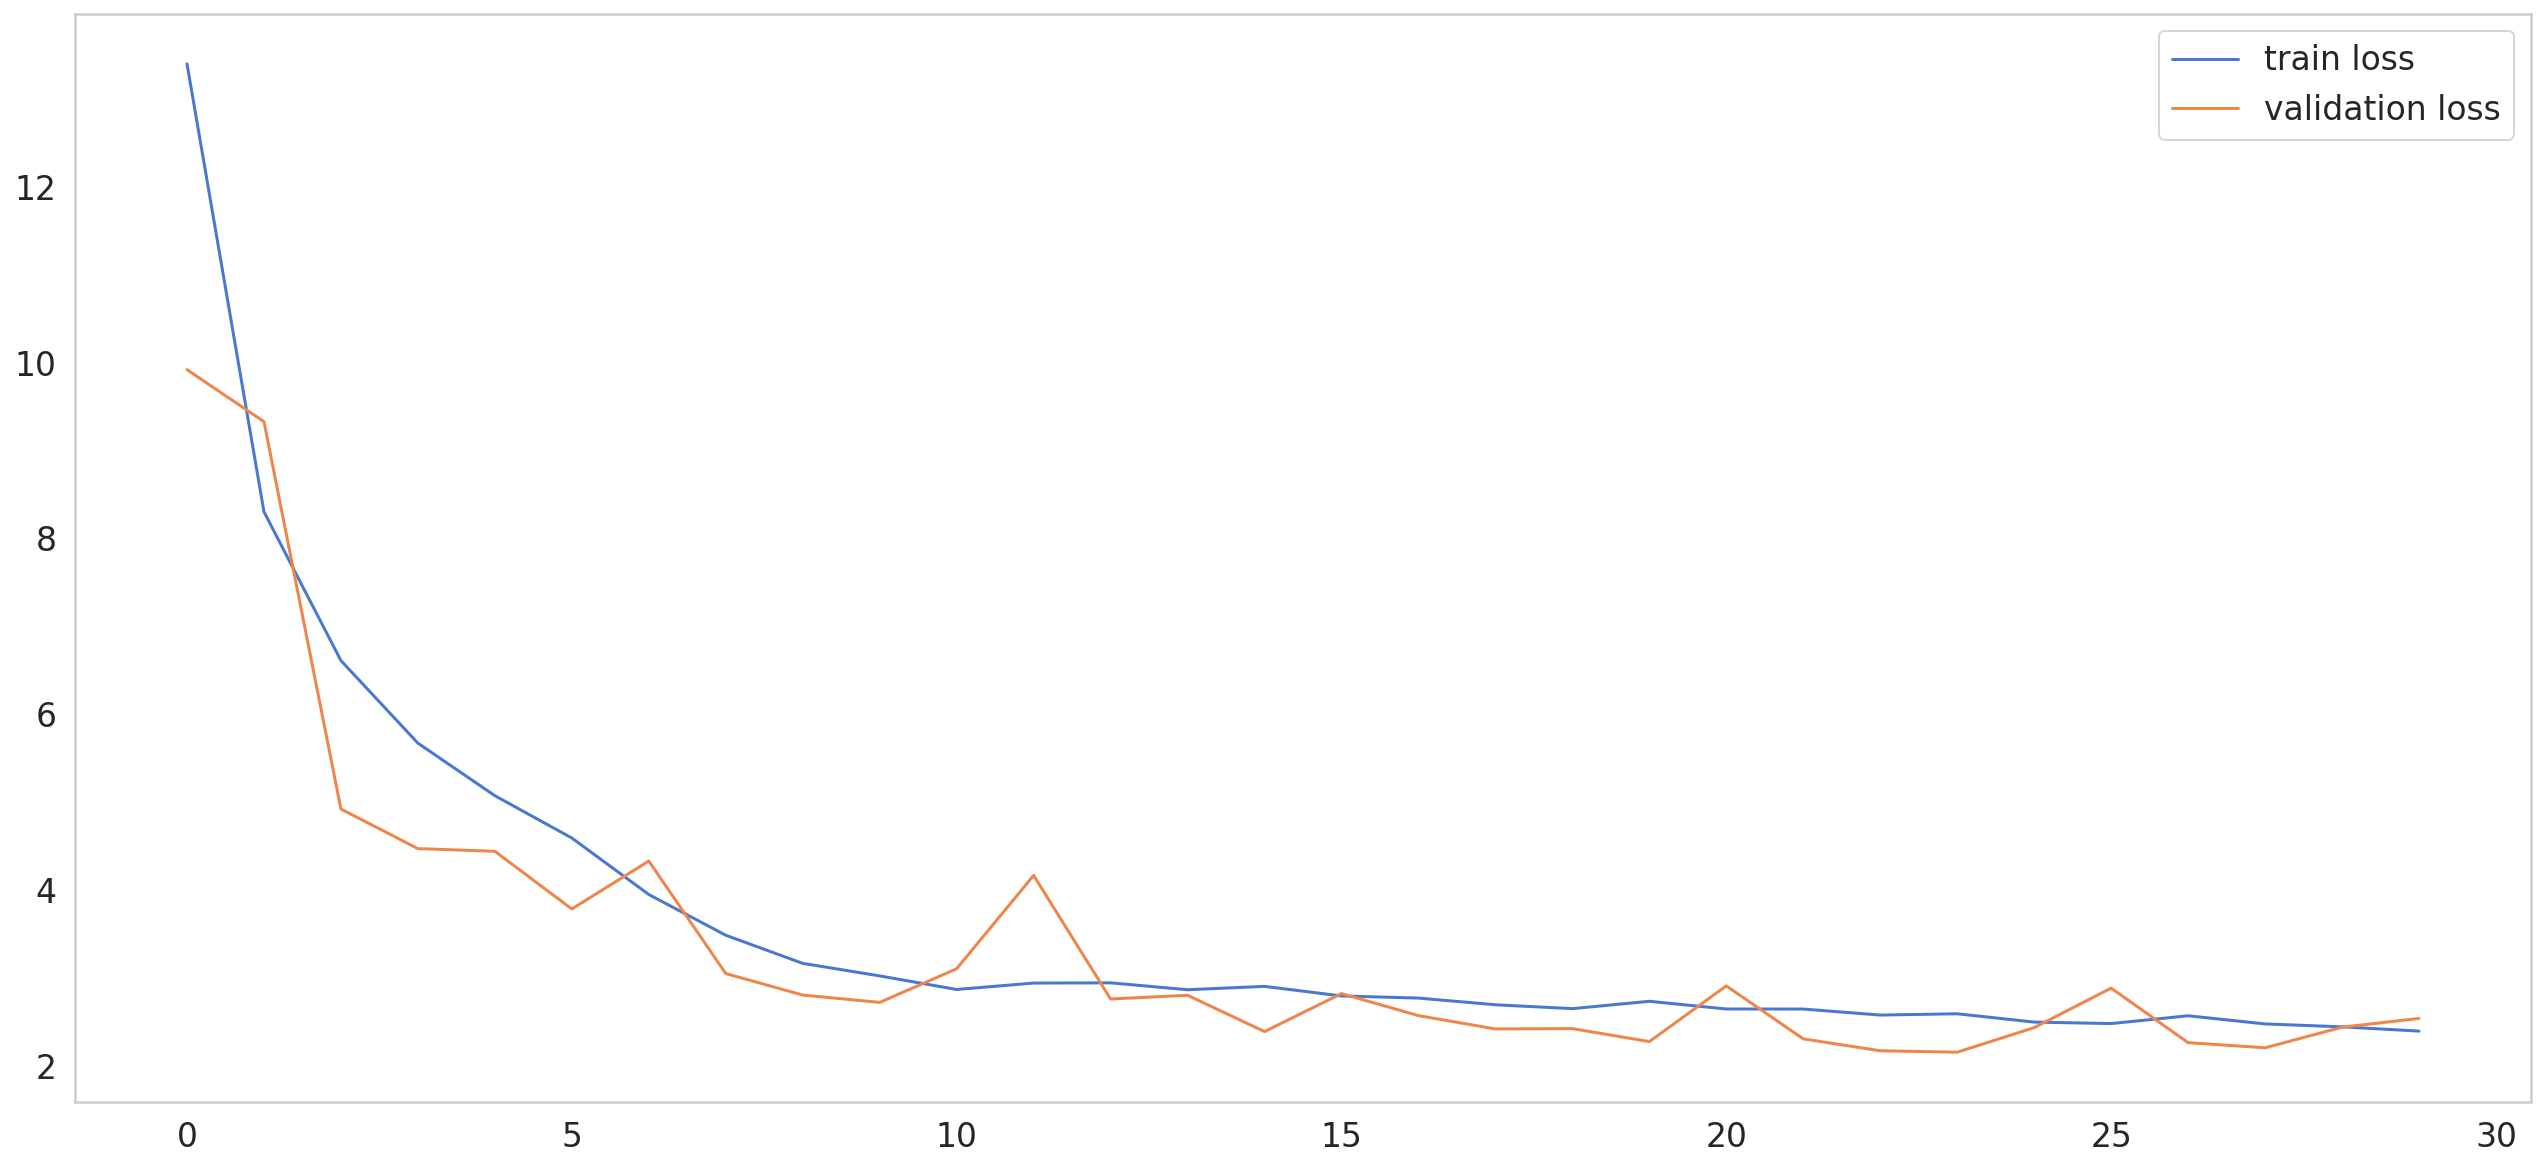

In [26]:
import matplotlib.pyplot as plta

plta.plot(history.history['loss'])
plta.plot(history.history['val_loss'])
plta.grid(False)
plt.legend(['train loss','validation loss'])
plta.show()

In [27]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [28]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train*D_max,train_predict*D_max))

277.0443007769521

In [29]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest*D_max,test_predict*D_max))

294.59176652135176

In [30]:
train_predict.shape

(18083, 1)

In [31]:
y_train_rs=y_train.reshape(-1,1)
y_train_rs.shape

(18083, 1)

In [32]:
df.demand.shape

(28080,)

In [33]:
train_predict.shape

(18083, 1)

In [34]:
test_predict.shape

(9659, 1)

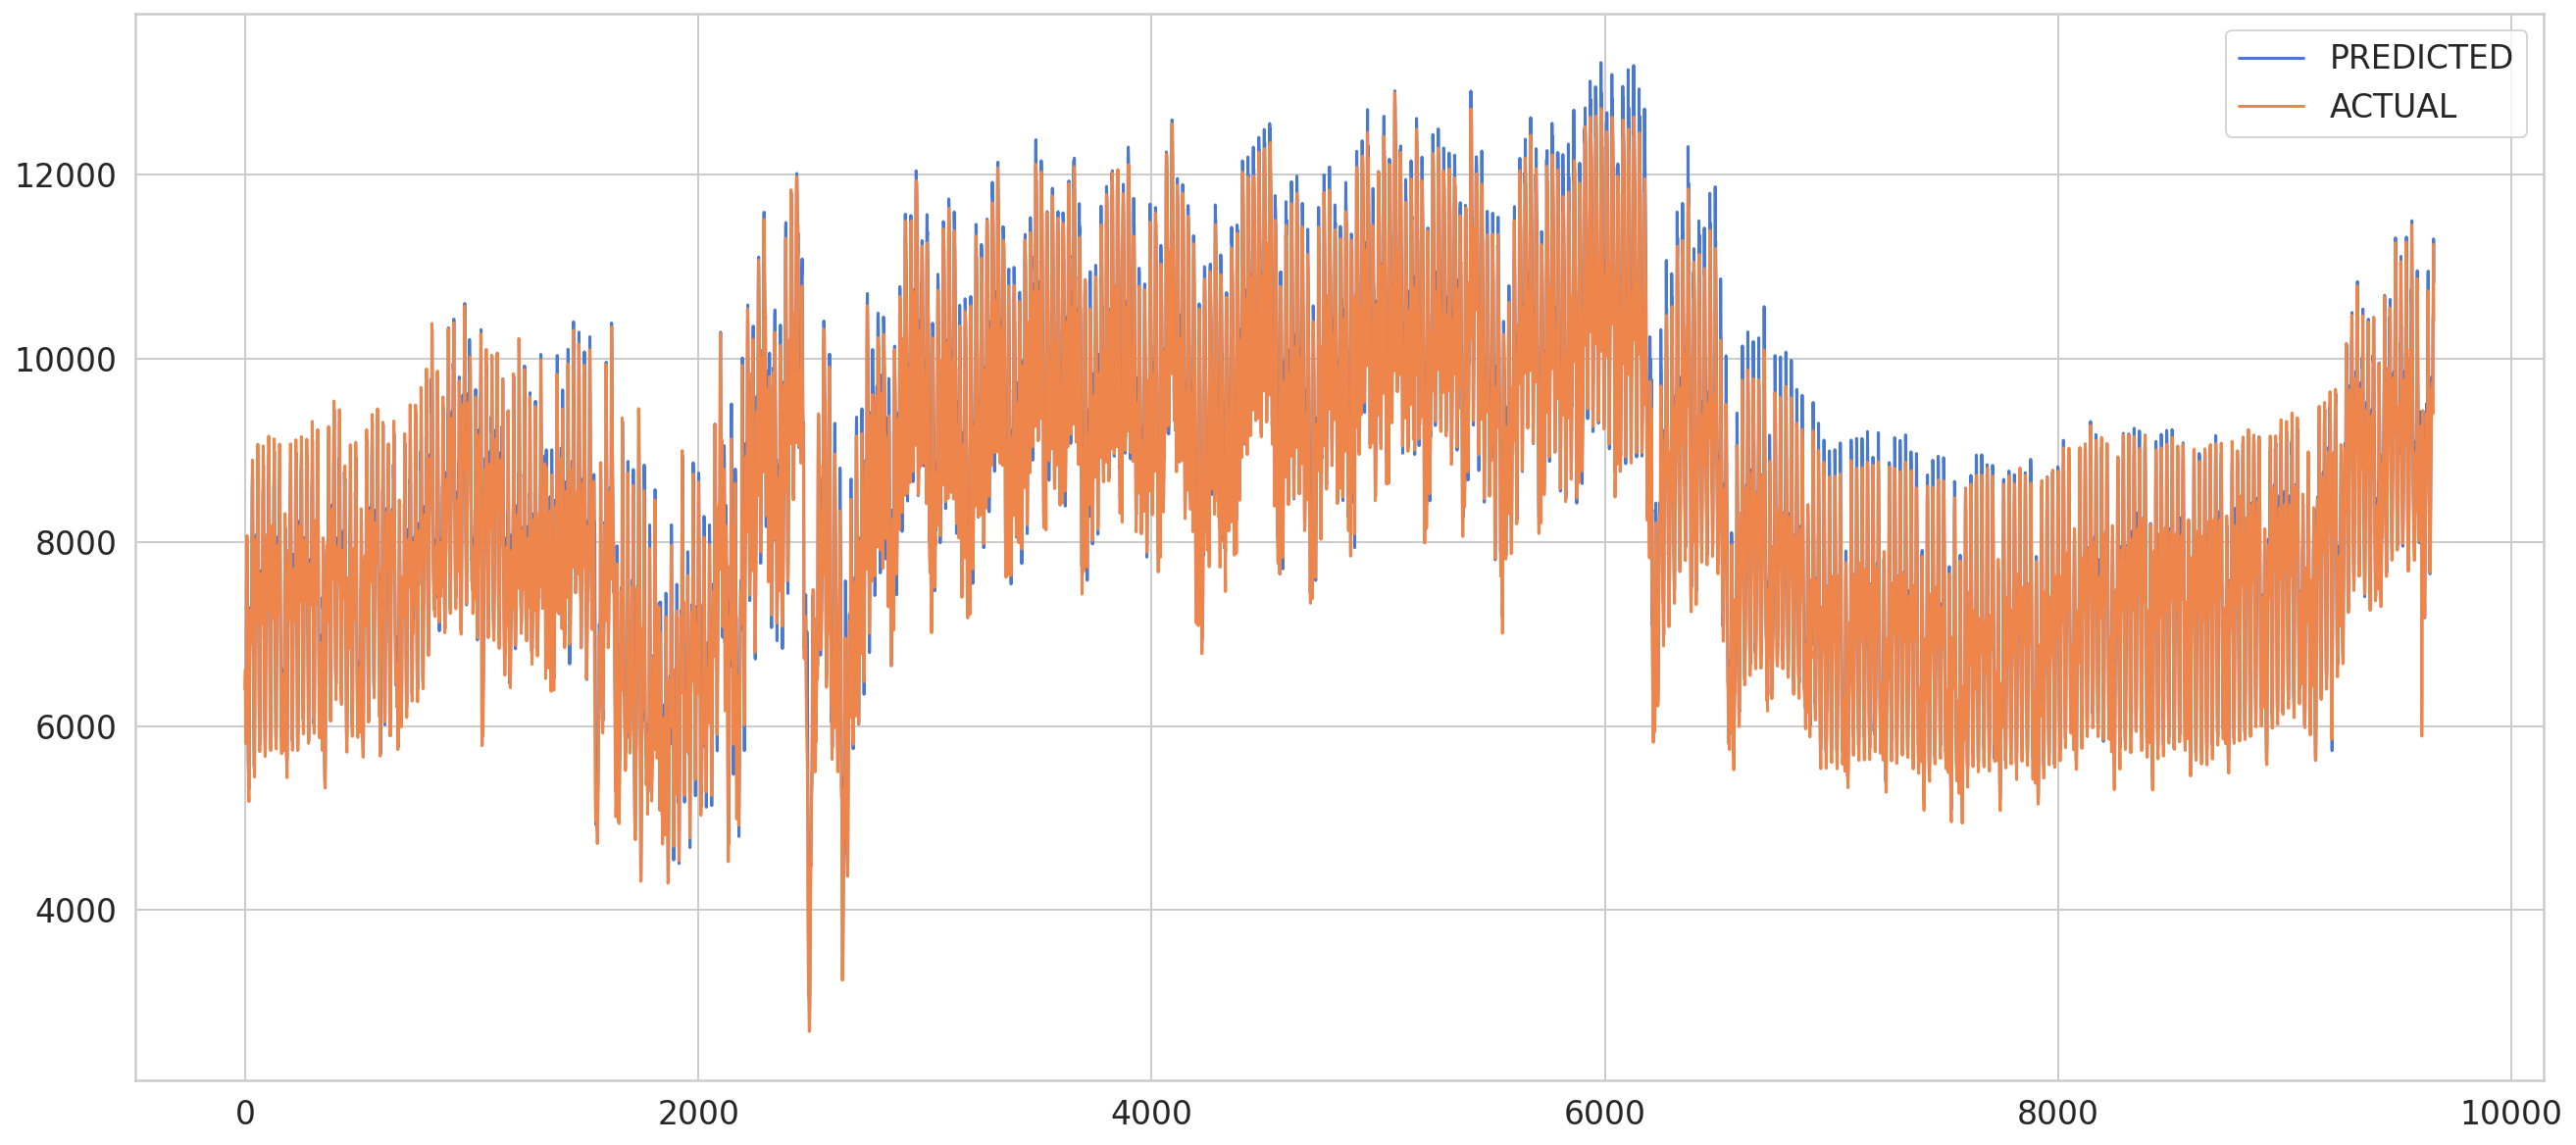

In [35]:
plt.plot(test_predict*D_max)
plt.plot(ytest*D_max)
plt.legend(['PREDICTED','ACTUAL'])

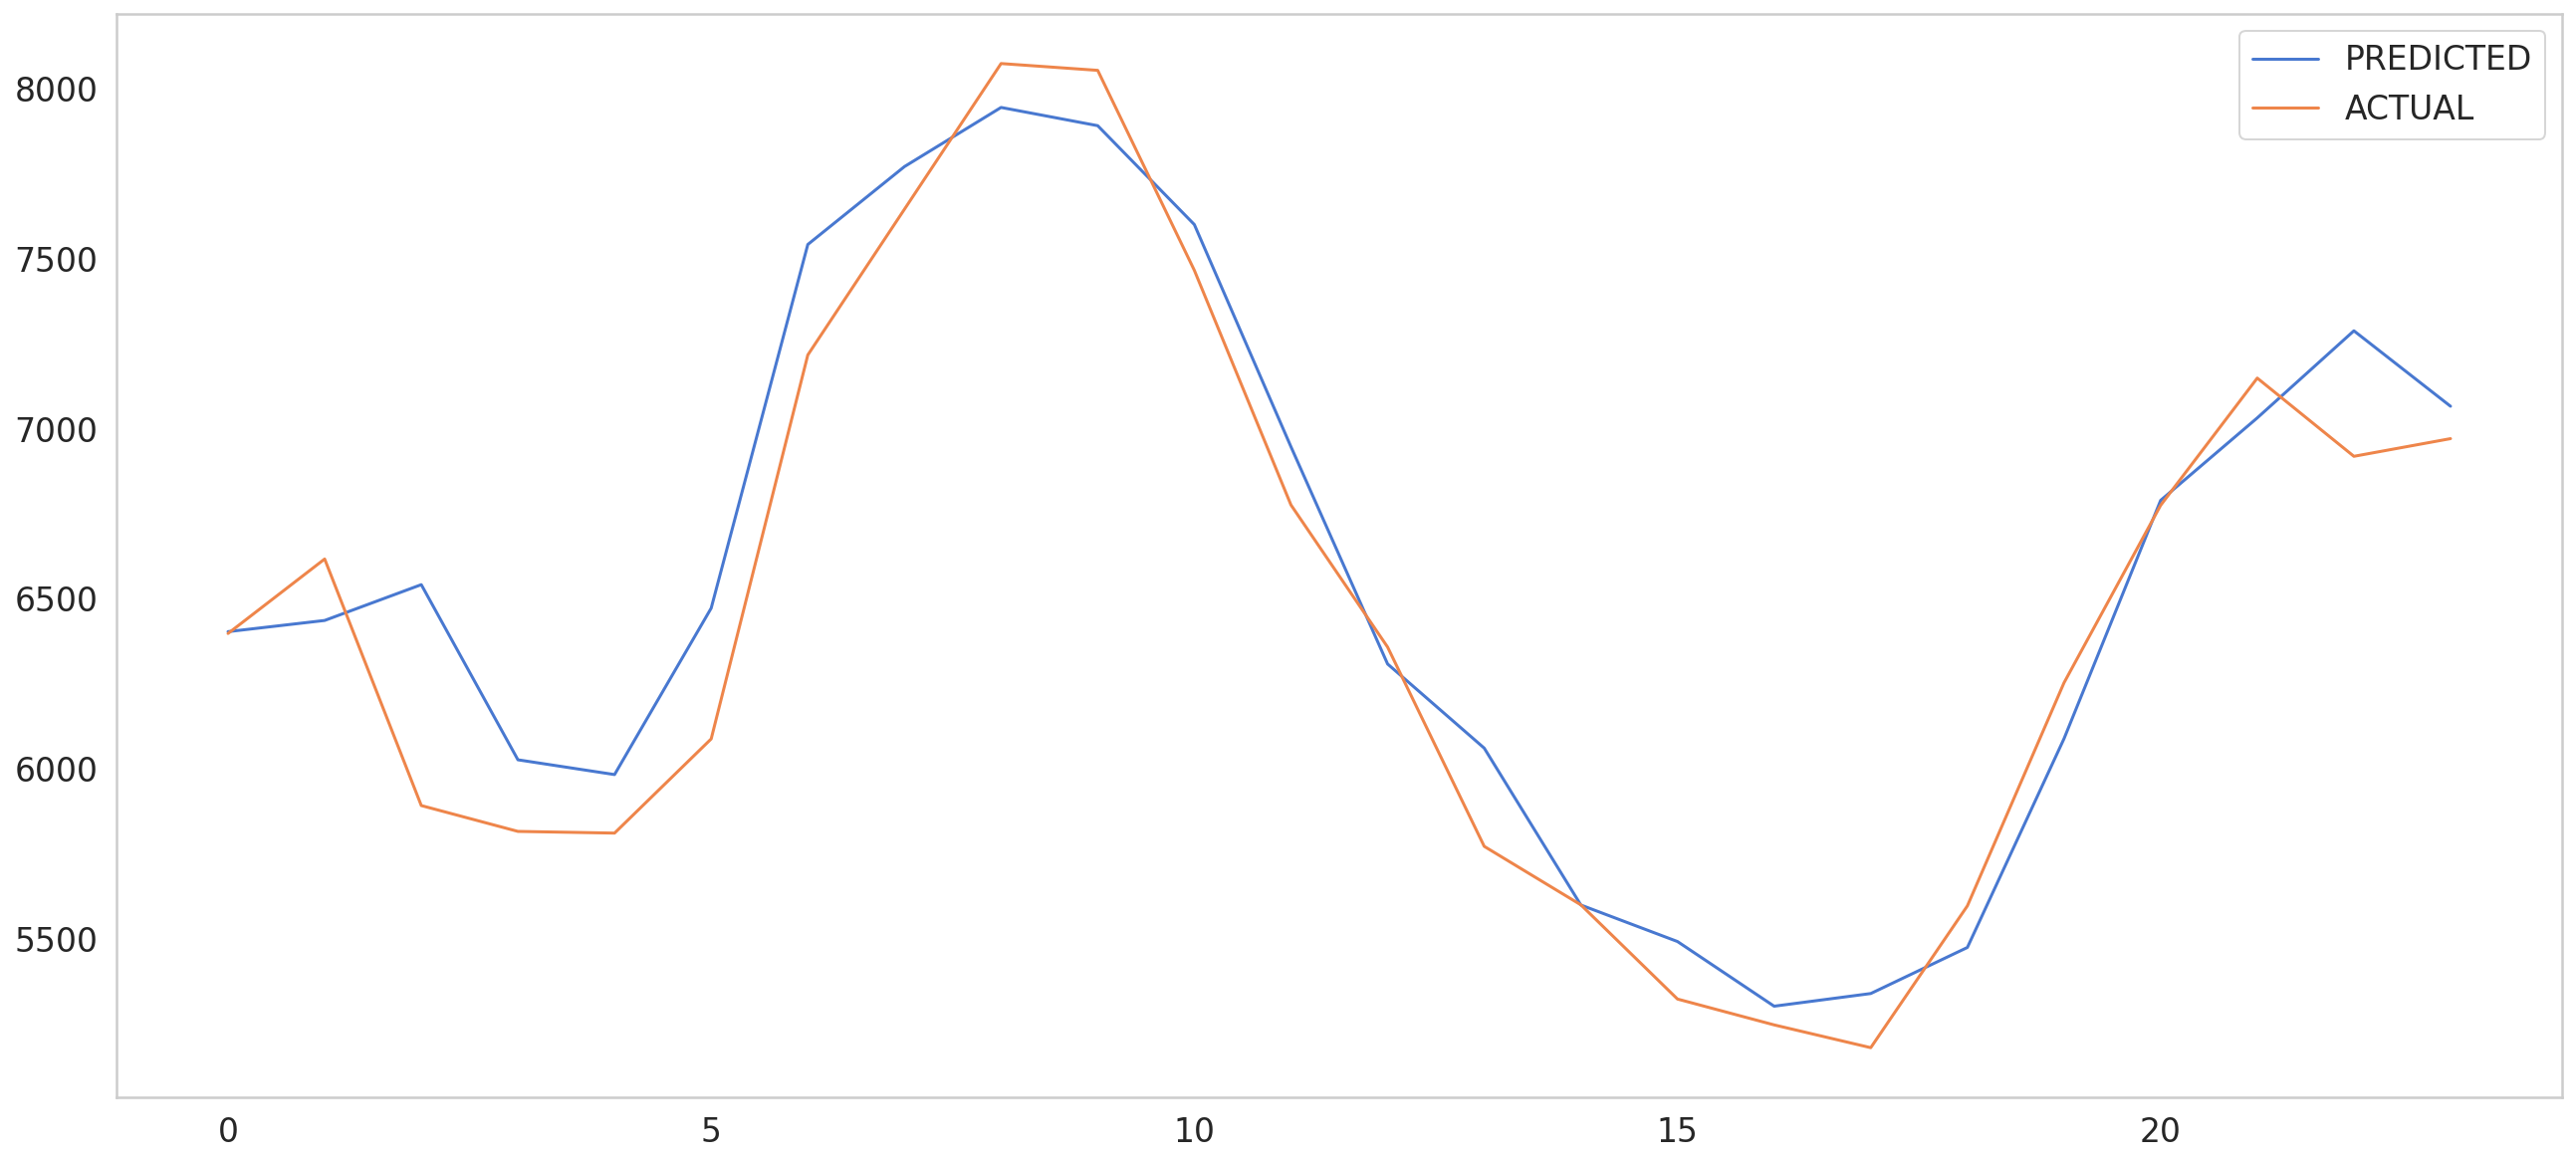

In [36]:
plt.plot(test_predict[:24]*D_max)
plt.plot(ytest[:24]*D_max)
plt.grid(False)
plt.legend(['PREDICTED','ACTUAL'])


In [37]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

In [38]:
from sklearn.ensemble import RandomForestRegressor
cls = RandomForestRegressor(n_estimators=1,min_samples_leaf=100)
cls.fit(d2_train_dataset,y_train)

RandomForestRegressor(min_samples_leaf=100, n_estimators=1)

In [39]:
nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

In [40]:
sk_pred=cls.predict(d2_test_dataset)

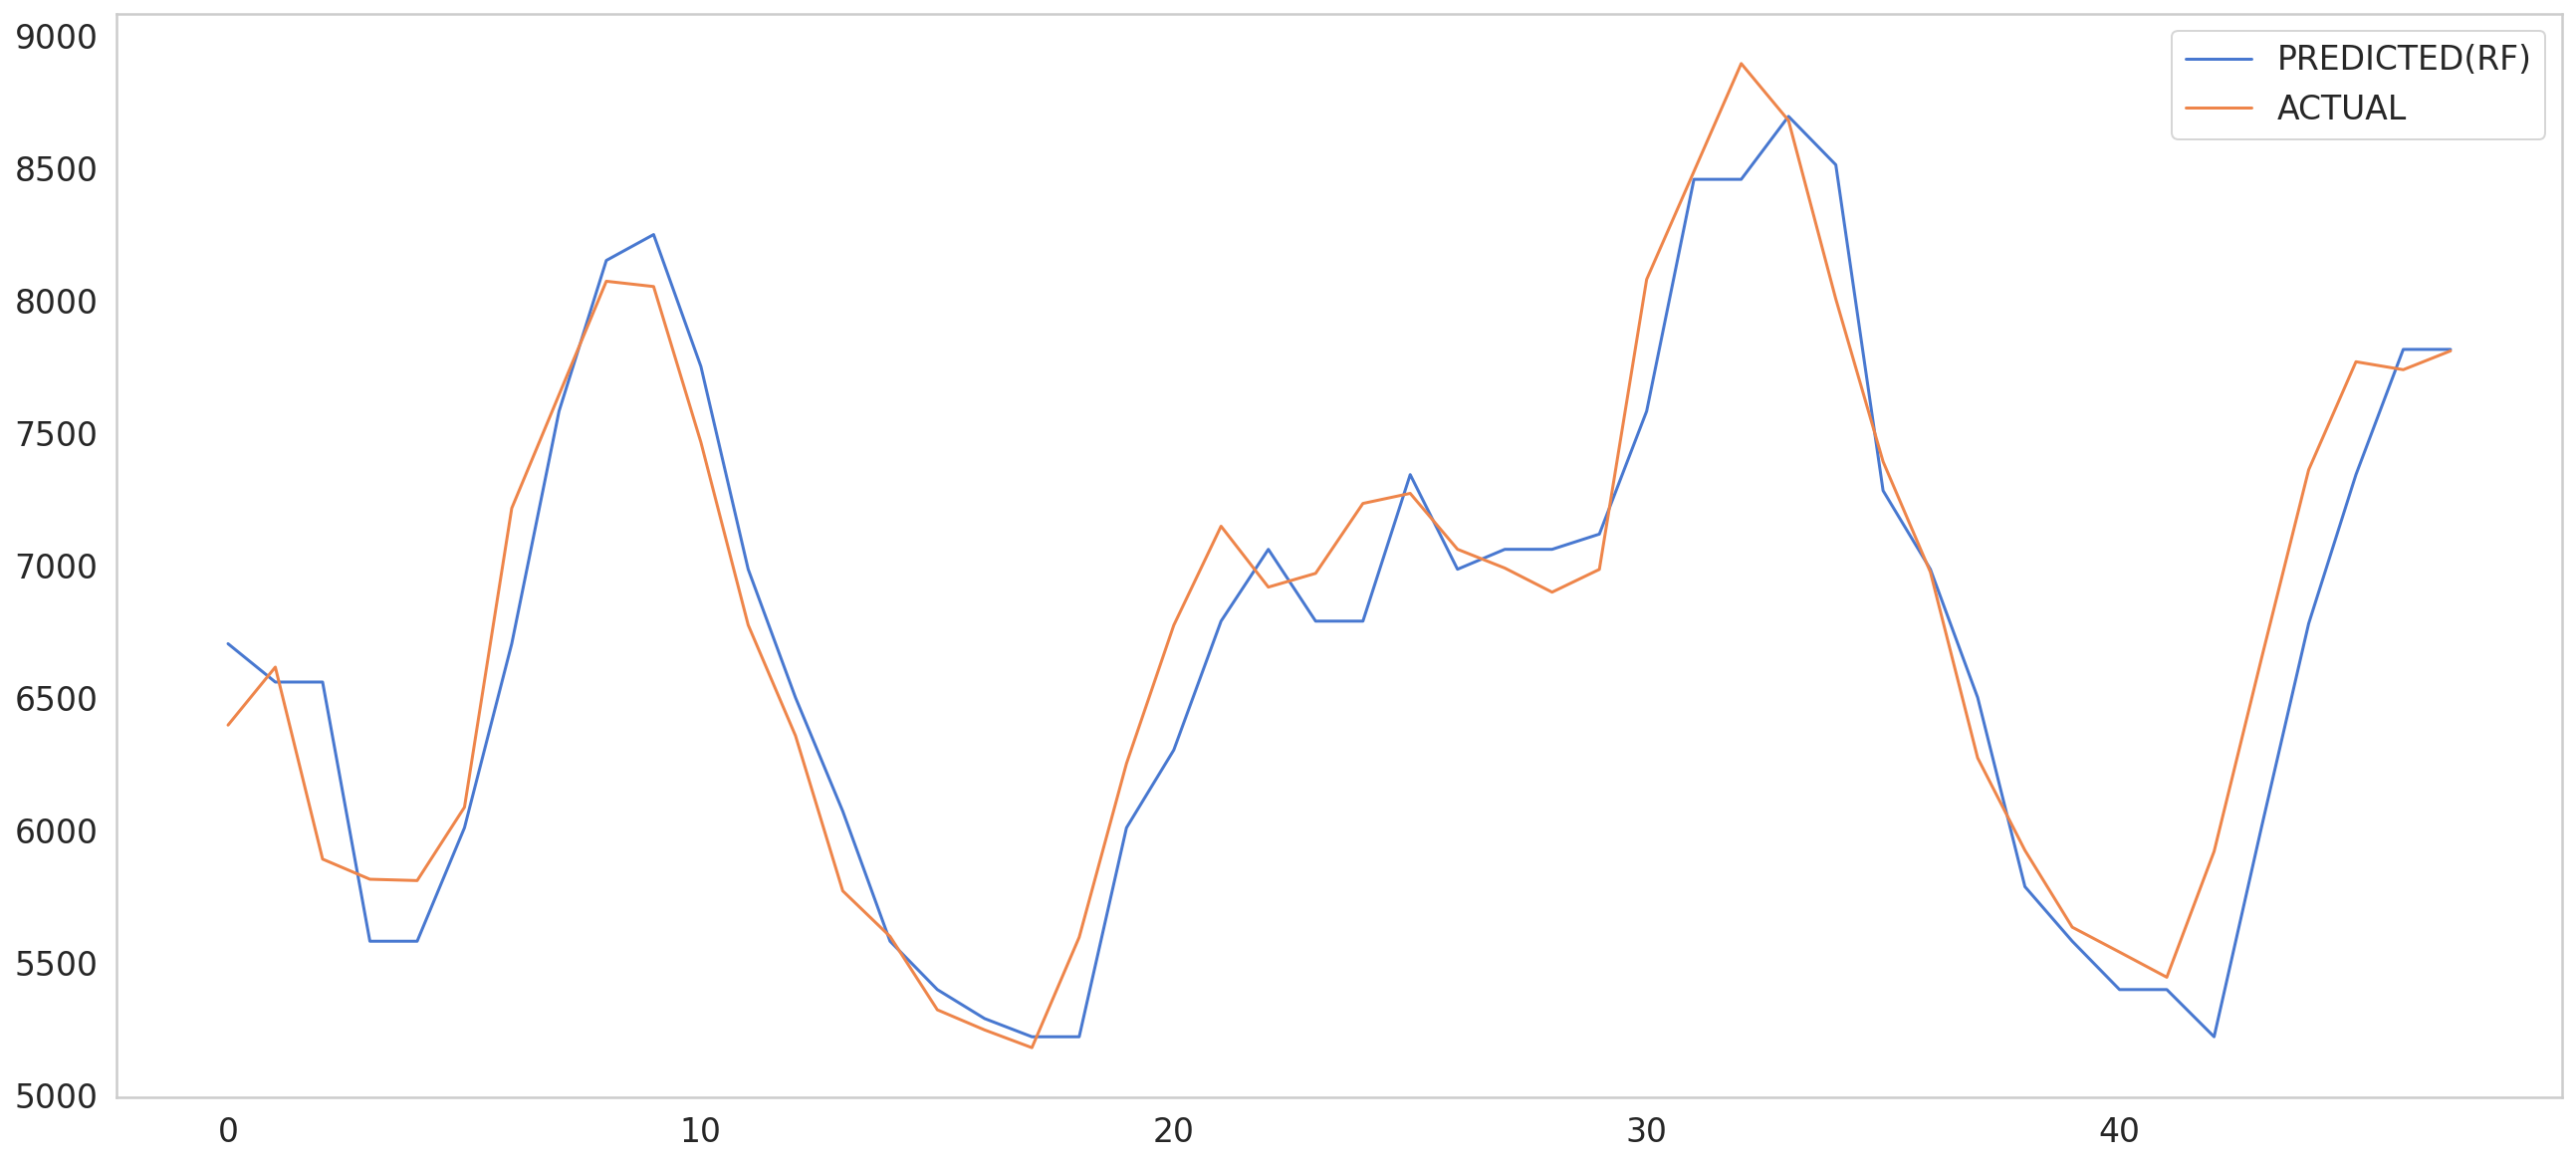

In [41]:
plt.plot(sk_pred[0:48]*D_max)
plt.plot(ytest[0:48]*D_max)
plt.grid(False)

plt.legend(['PREDICTED(RF)','ACTUAL'])

In [42]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [43]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [44]:
MAPE_RF=mean_absolute_percentage_error(ytest,sk_pred)
MAPE_RF

3.375798948058543

In [45]:
cls.score(d2_test_dataset,ytest)

0.9528331839565265